## Otimização utilizando o Modelo de Markowitz

### 1. Configuração Inicial

In [2]:
!pip install -U plotly

     |████████████████████████████████| 13.2MB 298kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
!pip install -q finquant

     |████████████████████████████████| 6.3MB 8.1MB/s 


In [4]:
!pip install -q bt

     |████████████████████████████████| 2.7MB 5.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [5]:
!pip install -q yfinance

In [6]:
from finquant.portfolio import build_portfolio
import bt
import yfinance as yf

from datetime import datetime
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Obtendo os dados

In [7]:
data_inicio = datetime(2015,1,1)
data_fim    = datetime(2020,12,31)

In [8]:
ibov = yf.download('^BVSP', start=data_inicio, end=data_fim)[['Adj Close']]
ibov 

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2015-01-02,48512.0
2015-01-05,47517.0
2015-01-06,48001.0
2015-01-07,49463.0
2015-01-08,49943.0
...,...
2020-12-22,116348.0
2020-12-23,117857.0
2020-12-28,119051.0


In [9]:
def get_tickers(indice):
  url = 'http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice={}&idioma=pt-br'.format(indice.upper())
  return (pd.read_html(url, decimal=',', thousands='.', index_col='Código')[0][:-1].index + '.SA').to_list()

In [10]:
def fix_col_names(df):
  return ['IBOV' if col =='^BVSP' else col.rstrip('.SA') for col in df.columns]

In [11]:
tickers = get_tickers('ibov')
tickers.remove('ASAI3.SA')

In [12]:
carteira = yf.download(tickers, start=data_inicio, end=data_fim)['Adj Close']
carteira.columns = fix_col_names(carteira)

[*********************100%***********************]  81 of 81 completed


In [13]:
carteira.head()

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BPAC11,BRAP4,BRDT3,BRFS3,BRKM5,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,COGN3,CPFE3,CPLE6,CRFB3,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,EGIE3,ELET3,ELET6,EMBR3,ENBR3,ENEV3,ENGI11,EQTL3,EZTC3,FLRY3,GGBR4,GNDI3,GOAU4,...,HAPV3,HGTX3,HYPE3,IGTA3,IRBR3,ITSA4,ITUB4,JBSS3,JHSF3,KLBN11,LAME4,LCAM3,LREN3,MGLU3,MRFG3,MRVE3,MULT3,NTCO3,PCAR3,PETR3,PETR4,PRIO3,QUAL3,RADL3,RAIL3,RENT3,SANB11,SBSP3,SULA11,SUZB3,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,VVAR3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,12.619536,NaN,2.530902,16.102884,11.357655,12.492571,18.853855,8.242382,NaN,9.809914,NaN,60.026928,12.556818,9.199005,21.140331,11.285233,17.588205,7.252496,13.185506,13.910287,2.169249,NaN,5.448579,3.998143,13.639720,7.681489,8.776349,17.368141,4.591455,5.738757,23.947771,6.234422,5.989072,11.441276,4.775079,11.858093,6.373186,8.182455,NaN,9.723442,...,NaN,6.136849,13.541846,21.845961,NaN,4.703486,13.875138,9.347877,1.943741,11.730689,13.370548,0.981403,11.248445,0.215415,5.597076,4.525375,13.177297,NaN,67.379715,8.161482,8.400567,0.440,17.092577,4.713555,NaN,9.686189,8.792006,13.981676,7.879971,18.820036,9.385139,10.088490,10.692099,21.623142,4.593882,16.528288,23.768299,6.543556,5.286594,16.707968
2015-01-05,12.391089,NaN,2.461708,15.768749,11.217659,12.517645,18.288551,7.851130,NaN,9.716004,NaN,58.887783,11.799515,9.103494,20.464613,10.963235,16.990421,7.065517,12.223323,13.730142,2.122371,NaN,5.125192,3.801384,13.460251,7.879957,8.166538,17.389448,4.502222,5.637442,23.417744,5.984474,5.561281,9.485857,4.592757,11.197781,6.106309,7.807686,NaN,9.265129,...,NaN,6.136849,13.566939,21.490961,NaN,4.718873,13.944867,9.392179,1.874011,11.443371,13.005754,0.941549,10.935743,0.219463,5.171857,4.444005,13.159431,NaN,67.379715,7.499496,7.682570,0.407,17.245934,4.681490,NaN,9.283518,8.729797,13.981676,7.717964,18.820036,9.350287,9.847879,10.363571,21.046919,4.315755,16.279737,23.296963,6.543556,5.322640,15.707762
2015-01-06,12.863731,NaN,2.485659,15.989141,11.516795,12.929439,19.065069,7.738101,NaN,10.149431,NaN,59.418743,11.547081,9.187066,20.522532,11.124233,16.649460,7.003191,11.403680,13.980783,2.122371,NaN,4.923320,4.108327,13.280781,8.100478,8.075890,17.740967,4.542781,5.861782,22.993721,6.084454,5.703878,9.485857,4.851481,11.472911,6.018678,8.628610,NaN,10.172769,...,NaN,6.136849,13.257458,22.246469,NaN,4.754776,14.170449,9.170666,1.882727,11.820984,13.330896,0.929095,11.061711,0.216571,5.092746,4.562930,13.814426,NaN,67.379715,7.309062,7.431271,0.367,17.501520,4.817295,NaN,9.471067,8.792006,13.940064,7.530039,18.820036,9.365224,9.830691,9.715474,21.076799,4.526748,16.932171,22.718771,6.543556,5.243684,14.790908
2015-01-07,13.044909,NaN,2.584127,16.692976,12.025332,13.443261,18.760674,8.251077,NaN,10.416712,NaN,62.073524,11.539866,9.539267,20.319817,11.959892,16.804447,7.003191,11.234408,14.474217,2.233466,NaN,4.995837,4.556938,13.164125,8.313648,8.718665,18.188354,4.705024,6.064412,22.820253,6.320118,5.846475,9.485857,4.809807,11.814075,5.974863,9.262149,NaN,10.918650,...,NaN,6.136849,14.052071,22.301083,NaN,4.934299,14.683122,9.427621,1.882727,11.944119,13.481574,0.944040,11.249927,0.223800,5.270745,4.663076,14.290789,NaN,67.379715,7.662724,7.781296,0.366,17.252323,4.900287,NaN,9.570355,9.158340,14.231350,7.510599,18.820036,9.380158,9.865064,9.646783,21.648750,4.795285,17.553537,23.498070,7.082436,5.183608,14.328691
2015-01-08,13.830949,NaN,2.549531,16.749851,12.051921,13.512504,18.704763,8.216298,NaN,10.568412,NaN,60.963345,11.568718,9.622840,19.653751,12.097890,17.269388,6.946531,12.116411,14.771848,2.212916,NaN,5.056595,4.407402,12.697503,8.379807,8.603296,18.374756,4.615792,5.869019,22.164938,6.498652,5.989072,9.485857,4.775079,11.830581,5.895199,9.047993,NaN,10.550203,...,NaN,6.136849,14.018611,22.674286,NaN,4.985592,14.912804,9.507366,2.057053,11.935911,13.322966,0.939058,11.263267,0.222066,5.369633,4.719409,14.138948,NaN,67.379715,8.179621,8.

In [14]:
carteira.tail()

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BPAC11,BRAP4,BRDT3,BRFS3,BRKM5,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,COGN3,CPFE3,CPLE6,CRFB3,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,EGIE3,ELET3,ELET6,EMBR3,ENBR3,ENEV3,ENGI11,EQTL3,EZTC3,FLRY3,GGBR4,GNDI3,GOAU4,...,HAPV3,HGTX3,HYPE3,IGTA3,IRBR3,ITSA4,ITUB4,JBSS3,JHSF3,KLBN11,LAME4,LCAM3,LREN3,MGLU3,MRFG3,MRVE3,MULT3,NTCO3,PCAR3,PETR3,PETR4,PRIO3,QUAL3,RADL3,RAIL3,RENT3,SANB11,SBSP3,SULA11,SUZB3,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,VVAR3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-22,15.436431,35.270000,19.654049,37.528252,21.661762,26.587635,28.675234,9.915247,92.282791,61.916553,21.142948,22.219999,23.070000,9.85,75.970001,13.108068,3.403111,11.578135,4.50,30.419497,6.296196,18.560080,17.909409,29.907663,18.530001,27.475805,12.83,42.435963,32.910664,32.934738,8.22,18.524466,13.9725,48.161411,21.998722,41.997021,25.977762,23.671474,77.028496,10.681919,...,15.178048,17.154402,32.803577,36.207943,7.19,11.269104,30.816317,23.286398,7.020636,25.680000,24.614569,26.458525,42.999805,25.133823,14.764020,18.690355,22.804153,50.049999,68.713615,26.924889,26.391766,11.936,32.582005,25.351871,19.150000,64.760101,43.140011,43.095592,40.291935,57.680000,30.631561,14.34,27.579929,22.819044,13.889596,83.192207,43.185215,15.940000,36.230171,31.694178
2020-12-23,15.426478,37.700001,19.559496,38.145721,22.124735,27.195911,28.645733,9.663638,92.421814,62.137405,21.200506,22.389999,23.240000,10.01,75.599998,13.346396,3.442115,11.854003,4.60,30.229731,6.485961,18.589094,17.670965,30.450365,18.940001,27.571539,13.15,42.828339,33.505661,33.415676,8.56,18.552952,14.5550,48.112606,22.018147,41.402634,25.812546,23.848568,76.760376,10.848518,...,14.998425,17.104593,33.049118,36.674309,7.24,11.536005,31.496742,23.015402,7.048831,25.139999,24.891582,27.478064,43.557728,24.944021,14.516800,18.534439,23.294777,51.689999,68.723068,27.505165,27.039951,13.226,33.137695,24.922350,19.200001,66.476929,44.112297,44.720345,40.470428,56.369999,30.622271,14.51,27.729494,23.161087,14.535854,83.594101,43.280357,16.129999,36.130669,32.393024
2020-12-28,15.695198,37.770000,20.051826,38.567165,22.311708,27.460808,29.235758,9.589087,94.556839,62.089397,21.258064,22.450001,23.030001,10.25,77.040001,13.366258,3.715144,12.138232,4.60,30.561819,6.637425,18.830885,18.255148,30.627975,19.680000,27.791729,13.19,43.985867,34.044876,33.970596,8.67,18.828300,14.6875,48.981346,22.377508,41.704700,26.366505,23.838728,77.455490,10.868117,...,15.128154,17.124517,34.276794,37.289520,8.11,11.664513,31.723549,23.083151,7.189808,25.440001,25.781981,27.823286,43.806797,25.223730,14.378356,18.670864,23.805025,52.000000,71.227760,27.708261,27.262461,13.308,32.609791,25.182060,19.650000,66.576744,44.909561,45.285046,40.639523,57.160000,31.254234,14.64,28.048569,23.356537,14.376776,83.546249,43.670444,16.590000,37.563553,32.560356
2020-12-29,15.874344,37.669998,20.156162,38.341740,22.309467,27.378782,29.560272,9.654319,94.775307,61.513245,21.210100,22.500000,23.389999,10.06,75.699997,13.674099,3.734646,12.096434,4.69,30.675682,6.602051,18.956619,18.360064,32.117931,19.730000,27.925758,13.46,43.642532,34.007687,34.072334,8.63,18.828300,14.7600,49.615822,22.319233,42.162670,26.541441,24.104368,79.411743,11.073916,...,15.487398,17.473185,34.368759,36.575085,8.21,11.733709,31.654520,23.238007,7.189808,25.570000,25.930380,28.150969,43.966206,25.253700,14.556355,18.709845,23.360001,51.939999,71.237221,27.727606,27.349531,13.564,33.035816,25.271961,19.530001,66.936073,44.880398,44.324066,42.076843,57.209999,31.198471,14.88,27.978771,23.561764,14.993207,83.316597,43.830280,16.580000,37.389416,32.737522
2020-12-30,15.575767,39.299999,20.208328,38.028107,21.875568,26.990923,29.137421,9.486580,93.255966,61.177158,21.229284,22.040001,23.570000,9.90,75.610001,13.376188,3.958238,12.171670,4.63,30.884422,6.799859,18.753511,18.057243,31.427223,20.580000,28.222534,13.37,43.103008,34.091358,34.220314,8.85,18.657394

### 3. Tratando a Base de Dados

In [15]:
# Opcional, caso o comando acima não funcione. Dados do Investing.com guardados no arquivo ibov-2010-2020.csv

#url  = 'https://raw.githubusercontent.com/codigoquant/data/main/ibov-2010-2020.csv'
#carteira = pd.read_csv(url, index_col=0)
#tickers  = carteira.columns

In [16]:
carteira.dropna(axis=1, thresh=carteira.shape[0]-10, inplace=True)
carteira.dropna(inplace=True)

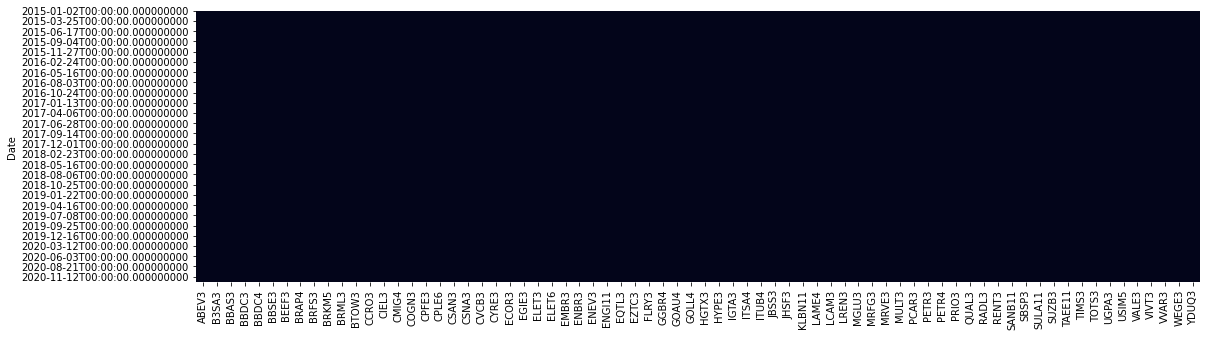

In [17]:
plt.figure(figsize=(18,5))
sns.heatmap(carteira.isnull(), cbar=False);

#### Detectando Outliers

In [18]:
px.line(carteira)
#fig.update_traces(marker=dict(size=3))

Output hidden; open in https://colab.research.google.com to view.

In [19]:
px.box(data_frame=carteira.pct_change().dropna())

Output hidden; open in https://colab.research.google.com to view.

In [20]:
def precos_iguais_consecutivos(df):
  n_zeros = (df.pct_change().dropna() == 0)
  c = lambda y: y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
  df2 = c(n_zeros.unstack()).unstack().T
  return df2.max()

In [21]:
consecutivos = precos_iguais_consecutivos(carteira)
px.bar(consecutivos)

In [22]:
#outliers = ['HGTX3', 'PCAR3', 'VVAR3','UGPA3', 'SUZB3','TAEE11', 'LREN3', 'LAME4', 'GGBR4','BRAP4', 'BRFS3']
#outliers = ['BRAP4', 'BRFS', 'VVAR3','UGPA3', 'SUZB3','TAEE11', 'LREN3', 'LAME4', 'GGBR4','BRAP4', 'BRFS3']

In [23]:
outliers = consecutivos[consecutivos > 20].index.to_list()

In [24]:
outliers

['HGTX3', 'PCAR3', 'SUZB3', 'VVAR3']

In [25]:
carteira.drop(outliers, axis=1, inplace=True)
carteira.shape

(1488, 68)

In [26]:
carteira.tail()

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,COGN3,CPFE3,CPLE6,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,EGIE3,ELET3,ELET6,EMBR3,ENBR3,ENEV3,ENGI11,EQTL3,EZTC3,FLRY3,GGBR4,GOAU4,GOLL4,HYPE3,IGTA3,ITSA4,ITUB4,JBSS3,JHSF3,KLBN11,LAME4,LCAM3,LREN3,MGLU3,MRFG3,MRVE3,MULT3,PETR3,PETR4,PRIO3,QUAL3,RADL3,RENT3,SANB11,SBSP3,SULA11,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-22,15.436431,19.654049,37.528252,21.661762,26.587635,28.675234,9.915247,61.916553,22.219999,23.070000,9.85,75.970001,13.108068,3.403111,11.578135,4.50,30.419497,6.296196,17.909409,29.907663,18.530001,27.475805,12.83,42.435963,32.910664,32.934738,8.22,18.524466,13.9725,48.161411,21.998722,41.997021,25.977762,23.671474,10.681919,23.299999,32.803577,36.207943,11.269104,30.816317,23.286398,7.020636,25.680000,24.614569,26.458525,42.999805,25.133823,14.764020,18.690355,22.804153,26.924889,26.391766,11.936,32.582005,25.351871,64.760101,43.140011,43.095592,40.291935,30.631561,14.34,27.579929,22.819044,13.889596,83.192207,43.185215,36.230171,31.694178
2020-12-23,15.426478,19.559496,38.145721,22.124735,27.195911,28.645733,9.663638,62.137405,22.389999,23.240000,10.01,75.599998,13.346396,3.442115,11.854003,4.60,30.229731,6.485961,17.670965,30.450365,18.940001,27.571539,13.15,42.828339,33.505661,33.415676,8.56,18.552952,14.5550,48.112606,22.018147,41.402634,25.812546,23.848568,10.848518,24.540001,33.049118,36.674309,11.536005,31.496742,23.015402,7.048831,25.139999,24.891582,27.478064,43.557728,24.944021,14.516800,18.534439,23.294777,27.505165,27.039951,13.226,33.137695,24.922350,66.476929,44.112297,44.720345,40.470428,30.622271,14.51,27.729494,23.161087,14.535854,83.594101,43.280357,36.130669,32.393024
2020-12-28,15.695198,20.051826,38.567165,22.311708,27.460808,29.235758,9.589087,62.089397,22.450001,23.030001,10.25,77.040001,13.366258,3.715144,12.138232,4.60,30.561819,6.637425,18.255148,30.627975,19.680000,27.791729,13.19,43.985867,34.044876,33.970596,8.67,18.828300,14.6875,48.981346,22.377508,41.704700,26.366505,23.838728,10.868117,24.250000,34.276794,37.289520,11.664513,31.723549,23.083151,7.189808,25.440001,25.781981,27.823286,43.806797,25.223730,14.378356,18.670864,23.805025,27.708261,27.262461,13.308,32.609791,25.182060,66.576744,44.909561,45.285046,40.639523,31.254234,14.64,28.048569,23.356537,14.376776,83.546249,43.670444,37.563553,32.560356
2020-12-29,15.874344,20.156162,38.341740,22.309467,27.378782,29.560272,9.654319,61.513245,22.500000,23.389999,10.06,75.699997,13.674099,3.734646,12.096434,4.69,30.675682,6.602051,18.360064,32.117931,19.730000,27.925758,13.46,43.642532,34.007687,34.072334,8.63,18.828300,14.7600,49.615822,22.319233,42.162670,26.541441,24.104368,11.073916,24.480000,34.368759,36.575085,11.733709,31.654520,23.238007,7.189808,25.570000,25.930380,28.150969,43.966206,25.253700,14.556355,18.709845,23.360001,27.727606,27.349531,13.564,33.035816,25.271961,66.936073,44.880398,44.324066,42.076843,31.198471,14.88,27.978771,23.561764,14.993207,83.316597,43.830280,37.389416,32.737522
2020-12-30,15.575767,20.208328,38.028107,21.875568,26.990923,29.137421,9.486580,61.177158,22.040001,23.570000,9.90,75.610001,13.376188,3.958238,12.171670,4.63,30.884422,6.799859,18.057243,31.427223,20.580000,28.222534,13.37,43.103008,34.091358,34.220314,8.85,18.657394,15.5250,50.299095,22.494057,41.802143,26.259602,24.055178,11.034717,24.940001,33.923054,36.862843,11.595317,31.191042,22.899260,7.340183,26.549999,26.009527,29.194502,43.378395,24.950001,14.348689,18.466227,23.530001,27.901690,27.417252,14.038,32.396774,25.012251,68.822586,43.927563,44.026852,41.428638,31.040482,14.65,28.636860,23.200176,14.525912,83.680214,45.090889,37.682961,32.402863


### 4. Preparando a Otimização

In [27]:
pfs = { ano:build_portfolio(data=carteira.loc[str(ano)]) for ano in carteira.index.year.unique() }
pfs

{2015: <finquant.portfolio.Portfolio at 0x7f72769f2310>,
 2016: <finquant.portfolio.Portfolio at 0x7f7276fd48d0>,
 2017: <finquant.portfolio.Portfolio at 0x7f72769f2710>,
 2018: <finquant.portfolio.Portfolio at 0x7f72769f2f50>,
 2019: <finquant.portfolio.Portfolio at 0x7f725c857410>,
 2020: <finquant.portfolio.Portfolio at 0x7f725cce2210>}

In [28]:
# Só entra na carteira ativos com peso maior que o peso_min
peso_min = 0.001

### 5. Otimização por Máximo Índice de Sharpe

In [29]:
pesos_max_sr = pd.DataFrame(index=carteira.index, columns=carteira.columns)

for ano in pfs.keys():
  pesos_max_sr.loc[pesos_max_sr.index.year == (ano+1),:] = pfs[ano].ef_maximum_sharpe_ratio().T.values

pesos_max_sr.dropna(inplace=True)
pesos_max_sr.where(pesos_max_sr > peso_min, 0, inplace=True)
pesos_max_sr

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,COGN3,CPFE3,CPLE6,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,EGIE3,ELET3,ELET6,EMBR3,ENBR3,ENEV3,ENGI11,EQTL3,EZTC3,FLRY3,GGBR4,GOAU4,GOLL4,HYPE3,IGTA3,ITSA4,ITUB4,JBSS3,JHSF3,KLBN11,LAME4,LCAM3,LREN3,MGLU3,MRFG3,MRVE3,MULT3,PETR3,PETR4,PRIO3,QUAL3,RADL3,RENT3,SANB11,SBSP3,SULA11,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0,0,0,0,0,0,0.0492849,0,0,0.0930797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0189702,0.0199455,0,0.0125931,0.0387056,0,0,0,0,0,0.0448113,0,0,0,0,0,0.409945,0,0,0,0,0,0,0,0,0,0,0,0.108516,0,0,0,0.204148,0,0,0,0,0,0,0,0,0
2016-01-05,0,0,0,0,0,0,0.0492849,0,0,0.0930797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0189702,0.0199455,0,0.0125931,0.0387056,0,0,0,0,0,0.0448113,0,0,0,0,0,0.409945,0,0,0,0,0,0,0,0,0,0,0,0.108516,0,0,0,0.204148,0,0,0,0,0,0,0,0,0
2016-01-06,0,0,0,0,0,0,0.0492849,0,0,0.0930797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0189702,0.0199455,0,0.0125931,0.0387056,0,0,0,0,0,0.0448113,0,0,0,0,0,0.409945,0,0,0,0,0,0,0,0,0,0,0,0.108516,0,0,0,0.204148,0,0,0,0,0,0,0,0,0
2016-01-07,0,0,0,0,0,0,0.0492849,0,0,0.0930797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0189702,0.0199455,0,0.0125931,0.0387056,0,0,0,0,0,0.0448113,0,0,0,0,0,0.409945,0,0,0,0,0,0,0,0,0,0,0,0.108516,0,0,0,0.204148,0,0,0,0,0,0,0,0,0
2016-01-08,0,0,0,0,0,0,0.0492849,0,0,0.0930797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0189702,0.0199455,0,0.0125931,0.0387056,0,0,0,0,0,0.0448113,0,0,0,0,0,0.409945,0,0,0,0,0,0,0,0,0,0,0,0.108516,0,0,0,0.204148,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,0,0,0,0,0,0,0.0653074,0,0,0,0,0,0,0,0,0,0,0.0606924,0,0,0,0,0,0,0,0,0,0,0.235889,0,0,0,0,0,0,0,0,0,0,0,0.0399477,0.11125,0,0,0,0,0,0,0,0,0,0,0.125716,0.013199,0.0577802,0,0,0,0.126282,0,0,0.163937,0,0,0,0,0,0
2020-12-23,0,0,0,0,0,0,0.0653074,0,0,0,0,0,0,0,0,0,0,0.0606924,0,0,0,0,0,0,0,0,0,0,0.235889,0,0,0,0,0,0,0,0,0,0,0,0.0399477,0.11125,0,0,0,0,0,0,0,0,0,0,0.125716,0.013199,0.0577802,0,0,0,0.126282,0,0,0.163937,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0.0653074,0,0,0,0,0,0,0,0,0,0,0.0606924,0,0,0,0,0,0,0,0,0,0,0.235889,0,0,0,0,0,0,0,0,0,0,0,0.0399477,0.11125,0,0,0,0,0,0,0,0,0,0,0.125716,0.013199,0.0577802,0,0,0,0.126282,0,0,0.163937,0,0,0,0,0,0


In [30]:
# Composição de Cada Carteira
ativos_max_sr = pesos_max_sr.resample('Y', kind='period').last()
for ano in ativos_max_sr.index:
  atual = ativos_max_sr.loc[ano]  
  print(atual[atual > 0].to_frame(),'\n')

            2016
BEEF3   0.049285
BRKM5   0.093080
EMBR3   0.018970
ENBR3   0.019945
ENGI11  0.012593
EQTL3   0.038706
HYPE3   0.044811
KLBN11  0.409945
RADL3   0.108516
SULA11  0.204148 

            2017
BRAP4   0.032783
CPFE3   0.091720
CVCB3   0.026916
ELET3   0.119383
ENGI11  0.033172
EQTL3   0.007341
FLRY3   0.263573
LCAM3   0.194509
MGLU3   0.087448
PRIO3   0.007208
RADL3   0.135946 

           2018
BRAP4  0.022701
CVCB3  0.097525
ENEV3  0.002228
FLRY3  0.032244
GOLL4  0.009014
LCAM3  0.314201
MGLU3  0.054590
PRIO3  0.183104
RADL3  0.001468
RENT3  0.097961
TIMS3  0.095169
TOTS3  0.017668
WEGE3  0.072127 

            2019
BRKM5   0.019537
BTOW3   0.029246
CMIG4   0.104640
CPFE3   0.404923
ENGI11  0.077873
LCAM3   0.114256
MGLU3   0.082847
SULA11  0.152664
VALE3   0.013127 

            2020
BEEF3   0.065307
CPLE6   0.060692
ENEV3   0.235889
JBSS3   0.039948
JHSF3   0.111250
PRIO3   0.125716
QUAL3   0.013199
RADL3   0.057780
SULA11  0.126282
TOTS3   0.163937 



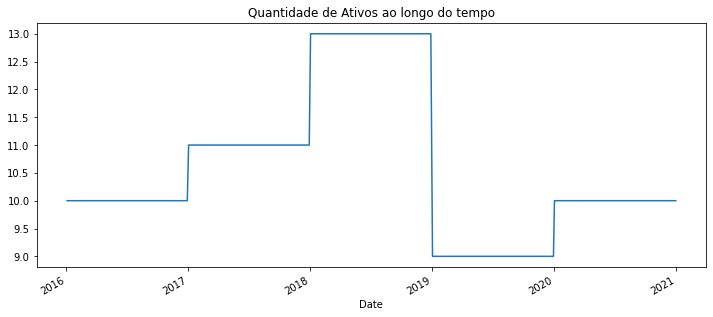

In [31]:
(pesos_max_sr > 0).sum(axis=1).plot(figsize=(12,5), title='Quantidade de Ativos ao longo do tempo');

### 6. Otimização por Mínima Volatilidade

In [32]:
pesos_min_vol = pd.DataFrame(index=carteira.index, columns=carteira.columns)

for ano in pfs.keys():
  pesos_min_vol.loc[pesos_min_vol.index.year == (ano+1),:] =  pfs[ano].ef_minimum_volatility().T.values

pesos_min_vol.dropna(inplace=True)
pesos_min_vol.where(pesos_min_vol > peso_min, 0, inplace=True)
pesos_min_vol

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,COGN3,CPFE3,CPLE6,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,EGIE3,ELET3,ELET6,EMBR3,ENBR3,ENEV3,ENGI11,EQTL3,EZTC3,FLRY3,GGBR4,GOAU4,GOLL4,HYPE3,IGTA3,ITSA4,ITUB4,JBSS3,JHSF3,KLBN11,LAME4,LCAM3,LREN3,MGLU3,MRFG3,MRVE3,MULT3,PETR3,PETR4,PRIO3,QUAL3,RADL3,RENT3,SANB11,SBSP3,SULA11,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.0596884,0,0,0,0,0,0,0,0.123947,0.00583738,0,0,0,0,0,0,0,0,0,0,0.0515604,0.00550051,0,0,0,0,0.0640415,0,0.0112005,0.0661264,0.0621474,0,0.095831,0,0,0,0.0227868,0,0,0,0.0260859,0,0.0680228,0,0.0744723,0,0,0,0,0,0,0,0,0.0269598,0,0,0,0,0.0105906,0.0845466,0.0305225,0,0,0,0,0.0470095,0.0631231,0
2016-01-05,0.0596884,0,0,0,0,0,0,0,0.123947,0.00583738,0,0,0,0,0,0,0,0,0,0,0.0515604,0.00550051,0,0,0,0,0.0640415,0,0.0112005,0.0661264,0.0621474,0,0.095831,0,0,0,0.0227868,0,0,0,0.0260859,0,0.0680228,0,0.0744723,0,0,0,0,0,0,0,0,0.0269598,0,0,0,0,0.0105906,0.0845466,0.0305225,0,0,0,0,0.0470095,0.0631231,0
2016-01-06,0.0596884,0,0,0,0,0,0,0,0.123947,0.00583738,0,0,0,0,0,0,0,0,0,0,0.0515604,0.00550051,0,0,0,0,0.0640415,0,0.0112005,0.0661264,0.0621474,0,0.095831,0,0,0,0.0227868,0,0,0,0.0260859,0,0.0680228,0,0.0744723,0,0,0,0,0,0,0,0,0.0269598,0,0,0,0,0.0105906,0.0845466,0.0305225,0,0,0,0,0.0470095,0.0631231,0
2016-01-07,0.0596884,0,0,0,0,0,0,0,0.123947,0.00583738,0,0,0,0,0,0,0,0,0,0,0.0515604,0.00550051,0,0,0,0,0.0640415,0,0.0112005,0.0661264,0.0621474,0,0.095831,0,0,0,0.0227868,0,0,0,0.0260859,0,0.0680228,0,0.0744723,0,0,0,0,0,0,0,0,0.0269598,0,0,0,0,0.0105906,0.0845466,0.0305225,0,0,0,0,0.0470095,0.0631231,0
2016-01-08,0.0596884,0,0,0,0,0,0,0,0.123947,0.00583738,0,0,0,0,0,0,0,0,0,0,0.0515604,0.00550051,0,0,0,0,0.0640415,0,0.0112005,0.0661264,0.0621474,0,0.095831,0,0,0,0.0227868,0,0,0,0.0260859,0,0.0680228,0,0.0744723,0,0,0,0,0,0,0,0,0.0269598,0,0,0,0,0.0105906,0.0845466,0.0305225,0,0,0,0,0.0470095,0.0631231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,0.0478836,0,0,0,0,0.0336795,0.00504195,0,0.0393688,0.00801677,0,0,0,0,0,0,0.128824,0,0,0,0,0,0,0,0,0,0.0678772,0,0.0409471,0.0843445,0,0,0,0,0,0,0.0407991,0,0,0.0492161,0,0,0.0723386,0,0,0,0,0,0,0,0,0,0.0203877,0,0.00131027,0,0,0,0.0436083,0.100938,0,0.0785944,0,0,0.0262069,0.110617,0,0
2020-12-23,0.0478836,0,0,0,0,0.0336795,0.00504195,0,0.0393688,0.00801677,0,0,0,0,0,0,0.128824,0,0,0,0,0,0,0,0,0,0.0678772,0,0.0409471,0.0843445,0,0,0,0,0,0,0.0407991,0,0,0.0492161,0,0,0.0723386,0,0,0,0,0,0,0,0,0,0.0203877,0,0.00131027,0,0,0,0.0436083,0.100938,0,0.0785944,0,0,0.0262069,0.110617,0,0
2020-12-28,0.0478836,0,0,0,0,0.0336795,0.00504195,0,0.0393688,0.00801677,0,0,0,0,0,0,0.128824,0,0,0,0,0,0,0,0,0,0.0678772,0,0.0409471,0.0843445,0,0,0,0,0,0,0.0407991,0,0,0.0492161,0,0,0.0723386,0,0,0,0,0,0,0,0,0,0.0203877,0,0.00131027,0,0,0,0.0436083,0.100938,0,0.0785944,0,0,0.0262069,0.110617,0,0


In [34]:
# Composição de Cada Carteira
ativos_min_vol = pesos_min_vol.resample('Y', kind='period').last()
for ano in ativos_min_vol.index:
  atual = ativos_min_vol.loc[ano]  
  print(atual[atual > 0].to_frame(),'\n')

            2016
ABEV3   0.059688
BRFS3   0.123947
BRKM5   0.005837
CVCB3   0.051560
CYRE3   0.005501
EMBR3   0.064042
ENEV3   0.011200
ENGI11  0.066126
EQTL3   0.062147
FLRY3   0.095831
HYPE3   0.022787
JBSS3   0.026086
KLBN11  0.068023
LCAM3   0.074472
QUAL3   0.026960
SULA11  0.010591
TAEE11  0.084547
TIMS3   0.030522
VIVT3   0.047009
WEGE3   0.063123 

            2017
ABEV3   0.147917
BEEF3   0.095057
BRKM5   0.008118
CPFE3   0.051226
CVCB3   0.012460
EMBR3   0.037514
ENGI11  0.153887
FLRY3   0.092607
HYPE3   0.022985
IGTA3   0.018733
KLBN11  0.059256
LCAM3   0.113649
MRFG3   0.007368
MRVE3   0.028832
RADL3   0.051475
TAEE11  0.037785
UGPA3   0.061129 

            2018
ABEV3   0.127317
BBSE3   0.009659
BEEF3   0.099661
BRKM5   0.018119
CIEL3   0.007445
CPFE3   0.120542
EGIE3   0.065133
EMBR3   0.044332
ENEV3   0.052902
EQTL3   0.066698
FLRY3   0.024975
HYPE3   0.027923
LCAM3   0.066161
PRIO3   0.013698
RADL3   0.004369
SULA11  0.042099
TAEE11  0.070593
TOTS3   0.066562
UGPA3   0.

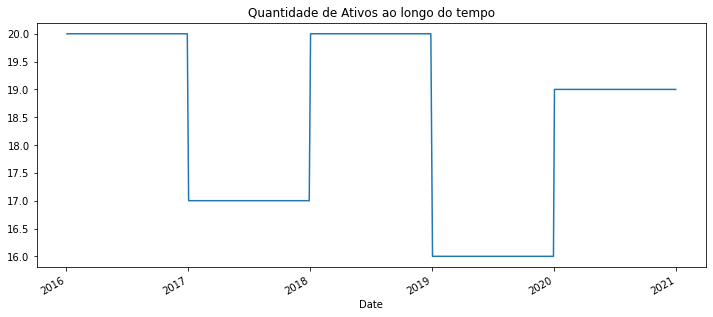

In [35]:
(pesos_min_vol > 0).sum(axis=1).plot(figsize=(12,5), title='Quantidade de Ativos ao longo do tempo');

### 7. Backtesting

In [48]:
benchmark = bt.Strategy('IBOV', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

In [49]:
s1 = bt.Strategy('Carteira Máximo Sharpe-Ratio', 
                [bt.algos.RunMonthly(),
                 bt.algos.SelectAll(),            
                 bt.algos.WeighTarget(pesos_max_sr),
                 bt.algos.Rebalance()])

In [51]:
s2 = bt.Strategy('Carteira Mínima Volatilidade', 
                [bt.algos.RunMonthly(),
                 bt.algos.SelectAll(),            
                 bt.algos.WeighTarget(pesos_min_vol),
                 bt.algos.Rebalance()])

In [52]:
s3 = bt.Strategy('Carteira Pesos Iguais', 
                [bt.algos.RunMonthly(),
                 bt.algos.SelectAll(),            
                 bt.algos.WeighEqually(),
                 bt.algos.Rebalance()])

In [55]:
bt_bmk = bt.Backtest(benchmark, ibov.loc[ibov.index.year > data_inicio.year])

bt1 = bt.Backtest(s1, carteira.loc[carteira.index.year > data_inicio.year])
bt2 = bt.Backtest(s2, carteira.loc[carteira.index.year > data_inicio.year])
bt3 = bt.Backtest(s3, carteira.loc[carteira.index.year > data_inicio.year])

In [ ]:
resultados = bt.run(bt_bmk, bt1, bt2, bt3)

In [56]:
resultados.display()

Stat                 IBOV        Carteira Máximo Sharpe-Ratio    Carteira Mínima Volatilidade    Carteira Pesos Iguais
-------------------  ----------  ------------------------------  ------------------------------  -----------------------
Start                2016-01-03  2016-01-03                      2016-01-03                      2016-01-03
End                  2020-12-30  2020-12-30                      2020-12-30                      2020-12-30
Risk-free rate       0.00%       0.00%                           0.00%                           0.00%

Total Return         177.48%     519.25%                         238.86%                         365.52%
Daily Sharpe         0.90        1.44                            1.33                            1.26
Daily Sortino        1.37        2.18                            1.97                            1.88
CAGR                 22.69%      44.10%                          27.70%                          36.09%
Max Drawdown         -46.30

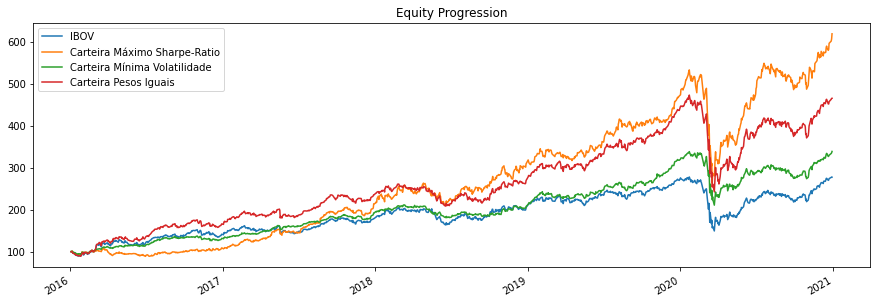

In [43]:
resultados.plot();

In [44]:
px.line(resultados.prices)

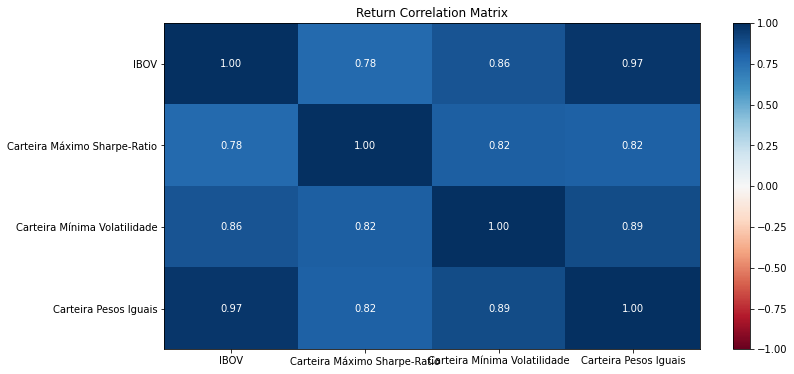

In [45]:
resultados.plot_correlation();

In [57]:
for port in resultados.keys():
  print(port)
  resultados.display_monthly_returns(port)
  print('\n')

IBOV
  Year    Jan    Feb     Mar    Apr     May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  ------  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----
  2016  -3.99   5.72   16.45   7.5    -9.84   6.13  10.94   1.01   0.79  10.98  -4.56  -2.65  41.6
  2017   7.22   3.02   -2.47   0.63   -4.03   0.3    4.7    7.31   4.79   0.02  -3.09   6.04  26.27
  2018  10.95   0.66   -0.13   0.86  -10.7   -5.11   8.71  -3.16   3.41  10.02   2.34  -1.78  14.77
  2019  10.66  -1.83   -0.17   0.97    0.69   4      0.83  -0.66   3.52   2.33   0.93   7.06  31.47
  2020  -1.88  -8.33  -29.53  10.07    8.43   8.62   8.15  -3.4   -4.73  -0.68  15.67   9.45   2.85


Carteira Máximo Sharpe-Ratio
  Year    Jan    Feb     Mar    Apr     May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  ------  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----
  2016  -0.47   1.67   -2.07  -2.25   -1.45  -5.75   8.08   0.34 